# Data Preparation

In [1]:
! pip install tensorflow opencv-python tqdm scikit-learn matplotlib seaborn mtcnn numpy pandas

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/376.0 MB 6.3 MB/s eta 0:01:00
   ---------------------------------------- 2.6/376.0 MB 6.9 MB/s eta 0:00:55
   ---------------------------------------- 4.5/376.0 MB 7.7 MB/s eta 0:00:49
    --------------------------------------- 6.6/376.0 MB 8.4 MB/s eta 0:00:45
    --------------------------------------- 9.2/376.0 MB 9.2 MB/s eta 0:00:40
   - -------------------------------------- 12.1/376.0 MB 10.1 MB/s eta 0:00:37
   - -------------------------------------- 15.7/376.0 MB 11.1 MB/s eta 0:00:33
   -- ------------------------------------- 19.9/376.0 MB 12.3 MB/s eta 0:00:29
   -- ------------------------------------- 24.6/376.0 MB 13.6 MB/s eta 0:00:26
   --- ------------------------------------ 29.6/376.0 MB 14.7 MB/s eta 0:00:24
   --- ------------------------------------ 34.9/376.0 MB 15.6 MB/s eta 0:00:22
   ---- ----------------------------------- 39.8/376.0 MB 1


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
! pip install kagglehub --upgrade

import kagglehub

# Download latest version
path = kagglehub.dataset_download("hungle3401/faceforensics")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Priyank Kapadia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.73G/2.73G [02:50<00:00, 17.2MB/s]

Extracting files...


Path to dataset files: C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\hungle3401\faceforensics\versions\1


# Data Preparation

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from mtcnn import MTCNN

# Update these paths to your local dataset location
FAKE_PATH = r"datasets\FF++\fake"
REAL_PATH = r"datasets\FF++\real"
OUTPUT_FRAME_SIZE = (160, 160)  # Size to which each frame will be resized
FRAME_COUNT = 16
MAX_VIDEOS = 200

if not os.path.exists(REAL_PATH) or not os.path.exists(FAKE_PATH):
    raise FileNotFoundError(f"Dataset paths not found: REAL_PATH={REAL_PATH}, FAKE_PATH={FAKE_PATH}. Please add the FaceForensics++ dataset.")

detector = MTCNN()

def extract_face(frame):
    results = detector.detect_faces(frame)
    if results:
        x, y, w, h = results[0]['box']
        x, y = max(0, x), max(0, y)
        face = frame[y:y+h, x:x+w]
        return cv2.resize(face, OUTPUT_FRAME_SIZE)
    return cv2.resize(frame, OUTPUT_FRAME_SIZE)

def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Could not open video file {video_path}, skipping.")
        return np.array([])
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = extract_face(frame)
        frames.append(frame)
    cap.release()
    return np.array(frames) if len(frames) > 0 else np.zeros((frame_count, output_size[0], output_size[1], 3), dtype=np.uint8)

data = []
labels = []

print("Processing real videos...")
real_videos = os.listdir(REAL_PATH)[:MAX_VIDEOS]
for video_file in tqdm(real_videos):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:
        data.append(frames)
        labels.append(0) # 0 for real videos

print("Processing fake videos...")
fake_videos = os.listdir(FAKE_PATH)[:MAX_VIDEOS]
for video_file in tqdm(fake_videos):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:
        data.append(frames)
        labels.append(1) # 1 for fake videos

if len(data) == 0:
    raise ValueError("No valid frames extracted. Check dataset or reduce MAX_VIDEOS/FRAME_COUNT.")

data = np.array(data)
labels = np.array(labels)

X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Data shapes: Train - {X_train.shape}, Val - {X_val.shape}, Test - {X_test.shape}")

# Save to local directory
os.makedirs('./data', exist_ok=True)
np.save('./data/X_train.npy', X_train)
np.save('./data/y_train.npy', y_train)
np.save('./data/X_val.npy', X_val)
np.save('./data/y_val.npy', y_val)
np.save('./data/X_test.npy', X_test)
np.save('./data/y_test.npy', y_test)

Processing real videos...


100%|██████████| 200/200 [59:24<00:00, 17.82s/it] 


Processing fake videos...


100%|██████████| 200/200 [42:46<00:00, 12.83s/it] 


Data shapes: Train - (280, 16, 160, 160, 3), Val - (60, 16, 160, 160, 3), Test - (60, 16, 160, 160, 3)


# Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],
    shear_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    channel_shift_range=10.0,
    fill_mode='nearest'
)

def sequence_augmentation(frames):
    if random.random() < 0.2:
        frames = frames.copy()
        np.random.shuffle(frames)
    if random.random() < 0.2:
        drop_idx = random.randint(0, len(frames)-1)
        frames[drop_idx] = frames[drop_idx-1] if drop_idx > 0 else frames[0]
    return frames

def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = datagen.random_transform(frame)
        augmented_frames.append(frame)
    augmented_frames = np.array(augmented_frames)
    augmented_frames = sequence_augmentation(augmented_frames)
    return augmented_frames

augmented_data = []
augmented_labels = []

for i in tqdm(range(len(X_train))):
    augmented_frames = augment_frames(X_train[i])
    augmented_data.append(augmented_frames)
    augmented_labels.append(y_train[i])

# Convert to numpy arrays and ensure correct dtype
augmented_data = np.array(augmented_data, dtype=np.float32)
augmented_labels = np.array(augmented_labels)

# Concatenate and check shapes
X_train_augmented = np.concatenate((X_train, augmented_data), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

print(f"Augmented Train Data: {X_train_augmented.shape}, Labels: {y_train_augmented.shape}")

# Check for empty arrays
assert X_train_augmented.shape[0] > 0, "X_train_augmented is empty!"
assert y_train_augmented.shape[0] > 0, "y_train_augmented is empty!"
assert X_train_augmented.shape[0] == y_train_augmented.shape[0], "Mismatched data and label counts!"

np.save('./data/X_train_augmented.npy', X_train_augmented)
np.save('./data/y_train_augmented.npy', y_train_augmented)


100%|██████████| 280/280 [00:12<00:00, 22.51it/s]


Augmented Train Data: (560, 16, 160, 160, 3), Labels: (560, 2)


# Model Architecture

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, TimeDistributed, 
                                     LSTM, Dropout, BatchNormalization, Input, Bidirectional)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_cnn_lstm_model(input_shape=(FRAME_COUNT, 160, 160, 3), label_smoothing=0.1):
    cnn_base = Xception(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
    cnn_base.trainable = True
    for layer in cnn_base.layers[:-30]:
        layer.trainable = False

    video_input = Input(shape=input_shape)
    x = TimeDistributed(cnn_base)(video_input)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = BatchNormalization()(x)
    # Bidirectional LSTM for richer temporal context
    x = Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.002)))(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.002))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=video_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=['accuracy']
    )
    return model

model = build_cnn_lstm_model()
model.summary()

# from tensorflow.keras.layers import Attention, Reshape, Permute

# # Replace LSTM line with the following for attention (if using return_sequences=True)
# x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.002)))(x)
# # Attention block
# attention = tf.keras.layers.Attention()([x, x])
# x = tf.keras.layers.GlobalAveragePooling1D()(attention)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 160, 160,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 5, 5, 2048) │    20,861,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 2048)       │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,115,754 (88.18 MB)

 Trainable params: 11,190,402 (42.69 MB)

 Non-trainable params: 11,925,352 (45.49 MB)

# Model Training

In [7]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow as tf

# Clear TensorFlow session to avoid variable creation errors
tf.keras.backend.clear_session()

# Compute class weights
import numpy as np
y_train_int = np.argmax(y_train, axis=1) if len(y_train.shape)>1 else y_train
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weight_dict = dict(enumerate(class_weights))

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6, 
        verbose=1
    ),
    
    ModelCheckpoint(
        'deepfake_model.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    )
]

# If you want to re-train, re-build the model here:
# model = build_cnn_lstm_model()

# Check if validation data is not empty
if X_val is not None and y_val is not None and len(X_val) > 0 and len(y_val) > 0:
    validation_data = (X_val, y_val)
else:
    print("Warning: Validation data is empty. Training without validation.")
    validation_data = None

# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=validation_data,
    epochs=100,
    batch_size=8,  # Adjust if memory allows
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=2
)

# Place model.save() here
os.makedirs("model", exist_ok=True)
model.save("model/deepfake_detection_model_final.keras")



Epoch 1/100

Epoch 1: val_loss improved from inf to 4.13117, saving model to deepfake_model.keras
70/70 - 285s - 4s/step - accuracy: 0.4589 - loss: 4.5608 - val_accuracy: 0.5333 - val_loss: 4.1312 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 4.13117 to 4.09125, saving model to deepfake_model.keras
70/70 - 214s - 3s/step - accuracy: 0.5679 - loss: 4.3655 - val_accuracy: 0.6500 - val_loss: 4.0913 - learning_rate: 1.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 4.09125 to 3.92351, saving model to deepfake_model.keras
70/70 - 214s - 3s/step - accuracy: 0.5839 - loss: 4.2803 - val_accuracy: 0.7333 - val_loss: 3.9235 - learning_rate: 1.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 3.92351 to 3.88245, saving model to deepfake_model.keras
70/70 - 250s - 4s/step - accuracy: 0.5929 - loss: 4.1601 - val_accuracy: 0.8000 - val_loss: 3.8825 - learning_rate: 1.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 3.88245 to 3.73062, saving model to deepfa

# Model Testing

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 11s/step
Test Accuracy: 90.00%
Classification Report:
              precision    recall  f1-score   support

        REAL       0.89      0.94      0.91        33
        FAKE       0.92      0.85      0.88        27

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



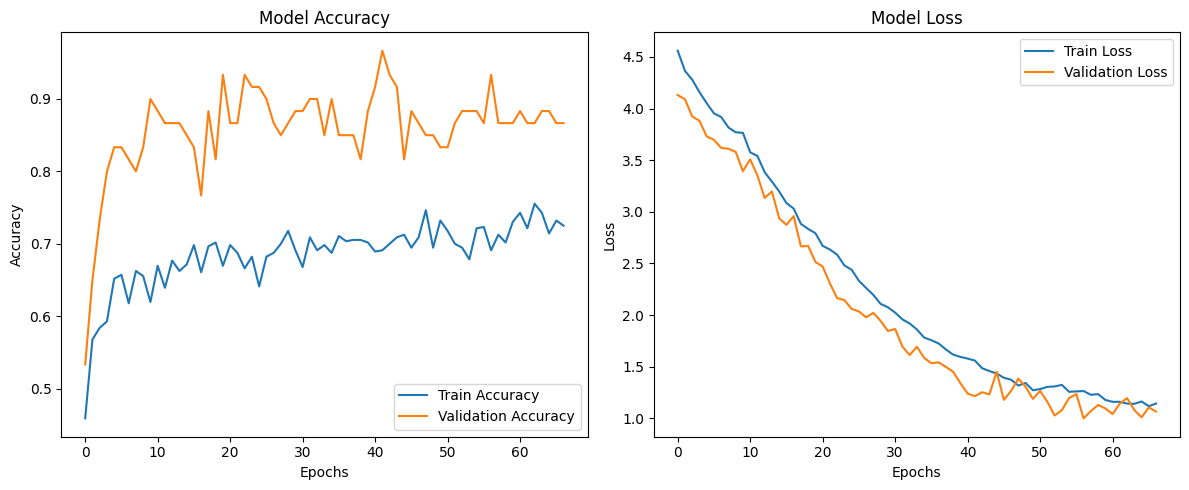

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


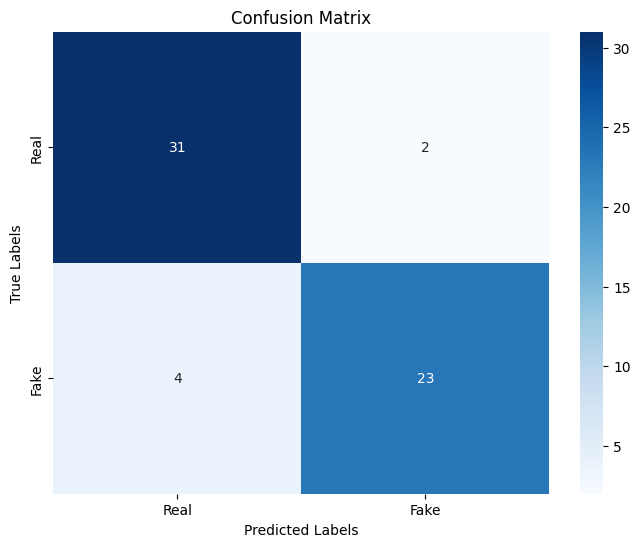

              precision    recall  f1-score   support

        Real       0.89      0.94      0.91        33
        Fake       0.92      0.85      0.88        27

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [8]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = load_model('model/deepfake_detection_model_final.keras')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['REAL', 'FAKE']))

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_labels = ['Real', 'Fake']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    print(classification_report(y_true, y_pred_classes, target_names=cm_labels))

plot_training_history(history)
plot_confusion_matrix(model, X_test, y_test)

# Real Time Prediction

In [11]:
# Real-Time Detection
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Function to extract frames from a video
def extract_frames(video_path, output_size=(160, 160), frame_count=16):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return np.array([])  # Return empty array if video fails to open
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)  # Uniform sampling

    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)  # Resize frame
        frames.append(frame)
    cap.release()

    # Pad if not enough frames
    while len(frames) < frame_count:
        if frames:
            frames.append(frames[-1].copy())
        else:
            frames.append(np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8))
    return np.array(frames, dtype=np.uint8)

# Function to predict video
def predict_video(video_path, model, output_size=(160, 160), frame_count=16):
    frames = extract_frames(video_path, output_size, frame_count)
    if len(frames) == 0:
        print(f"Error: No frames to predict for {video_path}")
        return

    # Ensure frames shape is (16, 160, 160, 3)
    frames = frames[:frame_count]
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension: (1, 16, 160, 160, 3)
    frames = frames / 255.0  # Normalize
    prediction = model.predict(frames)
    label = "FAKE" if np.argmax(prediction) == 1 else "REAL"
    confidence = float(prediction[0][np.argmax(prediction)])
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")

# Load the model with file existence check
model_path = 'model/deepfake_detection_model_final.keras'
if os.path.exists(model_path):
    loaded_model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
else:
    print(f"Error: Model file not found at {model_path}. Please run the training section first.")
    raise FileNotFoundError(f"Model file not found at {model_path}")

# Use the same dataset paths as data loading
FAKE_PATH = r"datasets\FF++\fake"
REAL_PATH = r"datasets\FF++\real"

# Get the first available video files (verify they exist)
real_videos = os.listdir(REAL_PATH)
fake_videos = os.listdir(FAKE_PATH)
if not real_videos or not fake_videos:
    print("Error: No video files found in REAL_PATH or FAKE_PATH. Check dataset input.")
else:
    real_sample_path = os.path.join(REAL_PATH, real_videos[0])  # First real video
    fake_sample_path = os.path.join(FAKE_PATH, fake_videos[0])  # First fake video

    # Test predictions
    print("Real Video Prediction:")
    predict_video(real_sample_path, loaded_model)

    print("Fake Video Prediction:")
    predict_video(fake_sample_path, loaded_model)


Model loaded successfully from model/deepfake_detection_model_final.keras
Real Video Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction: REAL (Confidence: 0.99)
Fake Video Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Prediction: REAL (Confidence: 0.66)
